# Final Work: Neural Networks and Geoscience

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## 1. Loading Data

In [5]:
df_train = pd.read_csv('lithology.csv', sep=';')
df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


## 2. Exploratory Data Analisys

In [6]:
df_train.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded'],
      dtype='object')

In [7]:
df_train.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65000.0    720803
30000.0    168937
65030.0    150455
70000.0     56320
80000.0     33329
99000.0     15245
70032.0     10513
88000.0      8213
90000.0      3820
74000.0      1688
86000.0      1085
93000.0       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [8]:
def lithology_number_to_name(x):
    if x == 30000.0:
        return 'Sandstone'
    elif x == 65030.0:
        return 'Sandstone/Shale'
    elif x == 65000.0:
        return 'Shale'
    elif x == 80000.0:
        return 'Marl'
    elif x == 74000.0:
        return 'Dolomite'
    elif x == 70000.0:
        return 'Limestone'
    elif x == 70032.0:
        return 'Chalk'
    elif x == 88000.0:
        return 'Halite'
    elif x == 86000.0:
        return 'Anhydrite'
    elif x == 99000.0:
        return 'Tuff'
    elif x == 90000.0:
        return 'Coal'
    elif x == 93000.0:
        return 'Basement'
    else: raise ValueError('Category Not Found')

df_train = df_train.assign(FORCE_2020_LITHOFACIES_LITHOLOGY_CAT = df_train.FORCE_2020_LITHOFACIES_LITHOLOGY.apply(lambda x: lithology_number_to_name(x)))

df_train.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded,FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68,Shale
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68,Shale
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68,Shale
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68,Shale
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68,Shale


In [9]:
df_train[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF']].describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,NPHI,PEF
count,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06
mean,2.184087e+03,4.856292e+05,6.679845e+06,-2.128037e+03,-6.280493e+01,-4.549949e+02,-2.845864e+01,1.189409e+00,-1.356686e+02,7.091370e+01,-3.455267e+02,-4.221022e+02
std,9.971821e+02,3.445166e+04,1.290797e+05,9.725712e+02,2.667498e+02,5.087190e+02,1.880157e+02,1.495506e+02,3.451085e+02,3.423149e+01,4.754047e+02,4.972170e+02
min,1.360860e+02,4.268988e+05,6.406641e+06,-5.395563e+03,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,1.092843e-01,-9.990000e+02,-9.990000e+02
25%,1.418597e+03,4.548018e+05,6.591140e+06,-2.804552e+03,8.874150e+00,-9.990000e+02,8.711777e-01,8.963877e-01,2.000454e+00,4.762722e+01,-9.990000e+02,-9.990000e+02
50%,2.076605e+03,4.769078e+05,6.732205e+06,-2.030516e+03,1.242991e+01,5.516068e-01,1.400712e+00,1.428157e+00,2.243782e+00,6.836763e+01,2.352654e-01,2.899809e+00
75%,2.864393e+03,5.201532e+05,6.784878e+06,-1.373344e+03,1.574931e+01,1.510922e+00,2.587100e+00,2.537876e+00,2.462978e+00,8.903551e+01,3.653732e-01,4.619021e+00
max,5.436632e+03,5.726328e+05,6.856661e+06,-1.110860e+02,2.827900e+01,2.193905e+03,1.988616e+03,1.999887e+03,3.457820e+00,1.076964e+03,9.995703e-01,3.831300e+02


In [10]:
df_train[['DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded']].describe()

,DTC,SP,BS,ROP,DCAL,DRHO,MUDWEIGHT,RMIC,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
count,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06
mean,7.842011e+01,-2.171530e+02,1.187501e+01,-4.795367e+02,-8.728321e+01,-1.612117e+02,-7.288450e+02,-8.474787e+02,-1.279143e+02,-1.371562e+02,2.641028e-01,-3.303349e+01,-1.377378e+02,-7.344170e-04,1.530734e-01,-1.377387e+02,6.627583e+00,4.129572e+01
std,2.045332e+02,4.701992e+02,3.052529e+00,1.184783e+03,2.841910e+02,3.675140e+02,4.441372e+02,3.616692e+02,3.482977e+02,3.445138e+02,1.806016e-01,1.786926e+02,3.444248e+02,3.516985e+00,3.212288e-01,3.444257e+02,3.125934e+00,2.282790e+01
min,-9.990000e+02,-9.990000e+02,6.000000e+00,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,0.000000e+00,-9.990000e+02,-9.990000e+02,-2.685117e+02,0.000000e+00,-9.990000e+02,0.000000e+00,-1.000000e+00
25%,8.526329e+01,-9.990000e+02,8.500000e+00,-9.990000e+02,-5.335999e-02,-2.112656e-02,-9.990000e+02,-9.990000e+02,2.852751e+00,3.509227e-01,1.209661e-01,-7.185020e-01,-1.644254e-02,-1.380630e+00,1.520000e-01,-5.005838e-01,5.000000e+00,2.400000e+01
50%,1.069366e+02,4.044000e+01,1.225000e+01,-9.990000e+02,3.736696e-01,-2.317054e-03,-9.990000e+02,-9.990000e+02,7.653391e+00,5.256773e-01,2.238263e-01,-1.633453e-02,-2.060652e-03,-1.548767e-03,1.520000e-01,-6.042549e-02,6.000000e+00,3.900000e+01
75%,1.401350e+02,7.039606e+01,1.225000e+01,1.502688e+01,1.693081e+00,1.489764e-02,1.330073e-01,-9.990000e+02,1.550824e+01,6.792460e-01,3.778281e-01,5.912170e-01,5.912662e-03,1.371843e+00,1.520000e-01,1.740417e-01,9.000000e+00,6.600000e+01
max,1.555313e+03,5.265473e+02,2.600000e+01,4.701512e+04,7.999847e+00,1.467912e+00,1.857309e+02,1.000000e+04,1.570291e+02,1.000000e+00,1.000000e+00,7.596500e+02,1.120613e+00,2.665444e+02,2.693440e+02,1.107053e+02,1.300000e+01,6.900000e+01


FORCE_2020_LITHOFACIES_LITHOLOGY_CAT
Anhydrite          AxesSubplot(0.125,0.125;0.775x0.755)
Basement           AxesSubplot(0.125,0.125;0.775x0.755)
Chalk              AxesSubplot(0.125,0.125;0.775x0.755)
Coal               AxesSubplot(0.125,0.125;0.775x0.755)
Dolomite           AxesSubplot(0.125,0.125;0.775x0.755)
Halite             AxesSubplot(0.125,0.125;0.775x0.755)
Limestone          AxesSubplot(0.125,0.125;0.775x0.755)
Marl               AxesSubplot(0.125,0.125;0.775x0.755)
Sandstone          AxesSubplot(0.125,0.125;0.775x0.755)
Sandstone/Shale    AxesSubplot(0.125,0.125;0.775x0.755)
Shale              AxesSubplot(0.125,0.125;0.775x0.755)
Tuff               AxesSubplot(0.125,0.125;0.775x0.755)
Name: DEPTH_MD, dtype: object

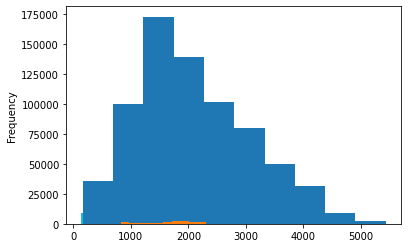

In [11]:
df_train.groupby(['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']).DEPTH_MD.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

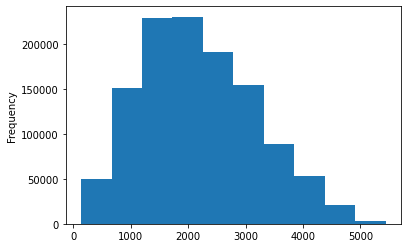

In [12]:
df_train.DEPTH_MD.plot(kind='hist')

## 3. Coding

In [13]:
#                              TODOS
# Terminar de analisar as colunas (todas sao continuas aparentemente)
# Fazer um baseline com alguns algoritmos de ML (DecisionTree & RandomForrest)
# Rodar o primeiro modelo somente com 1 camada
# Rodar o segundo modelo com 2 camadas
# Deixar o terceiro modelo mais otimizado
# Verificar se ha como usar a SMOTE
# Fazer as predições ao final com a hidden.csv

### 3.1 Split X and Y

In [14]:
X = df_train[['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF','DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded']]
Y = df_train[['FORCE_2020_LITHOFACIES_LITHOLOGY_CAT']]

### 3.2 Train/Test Split (Stratified due to unbalanced dataset per class)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.25)

### 3.3 Measuring the dataset size per class 

As we can see, some classes, like Basement and Anhydrite are very poor represented here, which can cause problemas.

In [16]:
y_train.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              540602
Sandstone          126702
Sandstone/Shale    112841
Limestone           42240
Marl                24997
Tuff                11434
Chalk                7885
Halite               6160
Coal                 2865
Dolomite             1266
Anhydrite             814
Basement               77
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

In [17]:
y_test.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Shale              180201
Sandstone           42235
Sandstone/Shale     37614
Limestone           14080
Marl                 8332
Tuff                 3811
Chalk                2628
Halite               2053
Coal                  955
Dolomite              422
Anhydrite             271
Basement               26
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

### 3.4 Standard Scale

As we can see above in Section 2.0, all data are continuous. To avoid problems with different scales, let's standard the data first.

In [18]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tranin_transform = std.fit_transform(X_train)
X_test_transform = std.transform(X_test)

### 3.5 Encode Y values

In [19]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()

y_train_enc = oe.fit_transform(y_train)
y_test_enc = oe.transform(y_test)

## 4. Architectures

### Baseline with Decision Tree (Unbalanced data)

In [20]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
model = clf.fit(X_tranin_transform, y_train_enc)

In [21]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_transform)
accuracy_score(y_test_enc, y_pred)

0.9235753243025274

### Rebalancing dataset

In [22]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(X, Y)

In [23]:
y_balanced.FORCE_2020_LITHOFACIES_LITHOLOGY_CAT.value_counts()

Halite             720803
Tuff               720803
Shale              720803
Marl               720803
Chalk              720803
Anhydrite          720803
Sandstone          720803
Basement           720803
Coal               720803
Sandstone/Shale    720803
Dolomite           720803
Limestone          720803
Name: FORCE_2020_LITHOFACIES_LITHOLOGY_CAT, dtype: int64

### Retrying baseline with oversampled data

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

std = StandardScaler()
oe = OrdinalEncoder()
clf = DecisionTreeClassifier(random_state=42)

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced,
                                                    stratify=y_balanced, 
                                                    test_size=0.25)

X_train_transform_balanced = std.fit_transform(X_train_balanced)
X_test_transform_balanced = std.transform(X_test_balanced)

y_train_enc_balanced = oe.fit_transform(y_train_balanced)
y_test_enc_balanced = oe.transform(y_test_balanced)

model_balanced = clf.fit(X_train_transform_balanced, y_train_enc_balanced)
y_pred_balanced = model_balanced.predict(X_test_transform_balanced)
accuracy_score(y_test_enc_balanced, y_pred_balanced)

0.9888374493446892